In [1]:
import pandas as pd

df1 = pd.read_parquet('../data/jp_morgan/sorted/transaction_metrics_final_aml_v5_cbflag_mod_metrics.parquet')
df2 = pd.read_parquet('../data/jp_morgan/sorted/transaction_metrics_final_fraud_v5_cbflag_mod_metrics.parquet')
# df3 = pd.read_parquet('../data/jp_morgan/sorted/transaction_metrics_final_ds3_v4_cbflag_mod.parquet')

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns

def temporal_entity_split(df, target_ratio=0.7):
    """
    Implements temporal split maintaining entity integrity
    
    Parameters:
    df: DataFrame with columns [Time_step, party_Id, Label]
    target_ratio: desired train split ratio (default 0.7)
    
    Returns:
    train_df, test_df, stats_dict
    """
    # Sort by timestamp
    df['Time_step'] = pd.to_datetime(df['Time_step'])
    df = df.sort_values('Time_step')
    
    # Calculate total transactions
    total_transactions = len(df)
    target_train_size = int(total_transactions * target_ratio)
    
    # Find first appearance of each entity
    entity_first_appearance = df.groupby('party_Id')['Time_step'].min()
    
    # Sort entities by first appearance
    sorted_entities = entity_first_appearance.sort_values().index
    
    # Calculate cumulative transactions for each entity
    entity_transactions = df.groupby('party_Id').size()
    cumulative_transactions = 0
    split_entity_idx = 0
    
    # Find split point that maintains entity integrity
    for entity in sorted_entities:
        cumulative_transactions += entity_transactions[entity]
        if cumulative_transactions >= target_train_size:
            split_entity_idx = sorted_entities.get_loc(entity)
            break
    
    # Split entities
    train_entities = sorted_entities[:split_entity_idx+1]
    test_entities = sorted_entities[split_entity_idx+1:]
    
    # Create train/test sets
    train_df = df[df['party_Id'].isin(train_entities)]
    test_df = df[df['party_Id'].isin(test_entities)]
    
    # Calculate statistics
    stats = calculate_split_statistics(df, train_df, test_df, target_ratio)
    
    return train_df, test_df, stats

def calculate_split_statistics(full_df, train_df, test_df, target_ratio):
    """Calculate comprehensive statistics about the split"""
    stats = {}
    
    # Overall dataset statistics
    stats['total_transactions'] = len(full_df)
    stats['total_entities'] = full_df['party_Id'].nunique()
    stats['full_date_range'] = (full_df['Time_step'].min(), full_df['Time_step'].max())
    
    # Class distribution - Full dataset
    full_class_dist = full_df['Label'].value_counts()
    stats['full_normal'] = full_class_dist.get(0, 0)
    stats['full_suspicious'] = full_class_dist.get(1, 0)
    stats['full_normal_pct'] = (stats['full_normal'] / stats['total_transactions']) * 100
    stats['full_suspicious_pct'] = (stats['full_suspicious'] / stats['total_transactions']) * 100
    
    # Train set statistics
    stats['train_transactions'] = len(train_df)
    train_class_dist = train_df['Label'].value_counts()
    stats['train_normal'] = train_class_dist.get(0, 0)
    stats['train_suspicious'] = train_class_dist.get(1, 0)
    stats['train_normal_pct'] = (stats['train_normal'] / stats['train_transactions']) * 100
    stats['train_suspicious_pct'] = (stats['train_suspicious'] / stats['train_transactions']) * 100
    
    # Test set statistics
    stats['test_transactions'] = len(test_df)
    test_class_dist = test_df['Label'].value_counts()
    stats['test_normal'] = test_class_dist.get(0, 0)
    stats['test_suspicious'] = test_class_dist.get(1, 0)
    stats['test_normal_pct'] = (stats['test_normal'] / stats['test_transactions']) * 100
    stats['test_suspicious_pct'] = (stats['test_suspicious'] / stats['test_transactions']) * 100
    
    # Split ratios
    stats['target_ratio'] = target_ratio
    stats['achieved_ratio'] = stats['train_transactions'] / stats['total_transactions']
    stats['ratio_difference'] = abs(stats['achieved_ratio'] - target_ratio)
    
    # Entity distribution
    stats['train_entities'] = train_df['party_Id'].nunique()
    stats['test_entities'] = test_df['party_Id'].nunique()
    stats['train_entities_pct'] = (stats['train_entities'] / stats['total_entities']) * 100
    stats['test_entities_pct'] = (stats['test_entities'] / stats['total_entities']) * 100
    stats['entity_cutoff'] = test_df['Time_step'].min()
    
    # Temporal coverage
    stats['train_period'] = (train_df['Time_step'].min(), train_df['Time_step'].max())
    stats['test_period'] = (test_df['Time_step'].min(), test_df['Time_step'].max())
    
    # Chi-square test for distribution similarity
    observed = np.array([
        [stats['train_normal'], stats['train_suspicious']],
        [stats['test_normal'], stats['test_suspicious']]
    ])
    chi2, p_value, _, _ = chi2_contingency(observed)
    stats['chi_square_p_value'] = p_value
    
    return stats

def print_split_statistics(stats, name):
    """Print formatted statistics"""
    print(f"{name} Overall Dataset Statistics:")
    print(f"Total Transactions: {stats['total_transactions']:,}")
    print(f"Total Entities: {stats['total_entities']:,}")
    print(f"Date Range: {stats['full_date_range'][0]} to {stats['full_date_range'][1]}\n")
    
    print("Class Distribution:")
    print("Full Dataset:")
    print(f"Normal transactions: {stats['full_normal']:,} ({stats['full_normal_pct']:.1f}%)")
    print(f"Suspicious transactions: {stats['full_suspicious']:,} ({stats['full_suspicious_pct']:.1f}%)\n")
    
    print("Training Set:")
    print(f"Total Transactions: {stats['train_transactions']:,} ({stats['achieved_ratio']*100:.1f}% of dataset)")
    print(f"Normal transactions: {stats['train_normal']:,} ({stats['train_normal_pct']:.1f}%)")
    print(f"Suspicious transactions: {stats['train_suspicious']:,} ({stats['train_suspicious_pct']:.1f}%)\n")
    
    print("Test Set:")
    print(f"Total Transactions: {stats['test_transactions']:,} ({(1-stats['achieved_ratio'])*100:.1f}% of dataset)")
    print(f"Normal transactions: {stats['test_normal']:,} ({stats['test_normal_pct']:.1f}%)")
    print(f"Suspicious transactions: {stats['test_suspicious']:,} ({stats['test_suspicious_pct']:.1f}%)\n")
    
    print("Statistical Analysis:")
    print(f"Chi-square test p-value: {stats['chi_square_p_value']:.4f}")
    print(f"Target vs Achieved split difference: {stats['ratio_difference']*100:.1f}%\n")
    
    print("Entity Distribution:")
    print(f"Training entities: {stats['train_entities']:,} ({stats['train_entities_pct']:.1f}%)")
    print(f"Testing entities: {stats['test_entities']:,} ({stats['test_entities_pct']:.1f}%)\n")
    
    print("Temporal Coverage:")
    print(f"Entity cutoff date: {stats['entity_cutoff']}")
    print(f"Training period: {stats['train_period'][0]} to {stats['train_period'][1]}")
    print(f"Testing period: {stats['test_period'][0]} to {stats['test_period'][1]}")

def plot_distributions(stats, name):
    """Create distribution plots"""
    # Set style
    # plt.style.use('seaborn-v0_8')
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Plot 1: Transaction Split
    split_data = {
        'Training': stats['train_transactions'],
        'Testing': stats['test_transactions']
    }
    ax1.bar(split_data.keys(), split_data.values(), color=['#25284F', '#5065A7'])
    ax1.set_title('Transaction Split Distribution')
    ax1.set_ylabel('Number of Transactions')
    
    # Add percentage labels
    for i, (key, value) in enumerate(split_data.items()):
        percentage = (value / stats['total_transactions']) * 100
        ax1.text(i, value, f'{percentage:.1f}%', ha='center', va='bottom')
    
    # Plot 2: Class Distribution Comparison
    labels = ['Full Dataset', 'Training Set', 'Testing Set']
    normal = [stats['full_normal'], stats['train_normal'], stats['test_normal']]
    suspicious = [stats['full_suspicious'], stats['train_suspicious'], stats['test_suspicious']]
    
    x = np.arange(len(labels))
    width = 0.35
    
    ax2.bar(x - width/2, normal, width, label='Normal', color='#B2CAF5')
    ax2.bar(x + width/2, suspicious, width, label='Suspicious', color='#6BA0AC')
    
    ax2.set_title('Class Distribution Comparison')
    ax2.set_ylabel('Number of Transactions')
    ax2.set_xticks(x)
    ax2.set_xticklabels(labels)
    ax2.legend()
    
    # Add percentage labels
    def add_percentages(ax, values, positions, total_values):
        for i, (value, total) in enumerate(zip(values, total_values)):
            percentage = (value / total) * 100
            ax.text(positions[i], value, f'{percentage:.1f}%', ha='center', va='bottom')
    
    totals = [stats['total_transactions'], stats['train_transactions'], stats['test_transactions']]
    add_percentages(ax2, normal, x - width/2, totals)
    add_percentages(ax2, suspicious, x + width/2, totals)

    plt.tight_layout()
    plt.show()

    fig.savefig(f'../data/split/{name}_split_distribution.png', dpi=300, transparent=True)


ds1 Overall Dataset Statistics:
Total Transactions: 1,391,164
Total Entities: 31,259
Date Range: 2022-01-07 00:02:00 to 2027-12-04 13:20:00

Class Distribution:
Full Dataset:
Normal transactions: 1,108,321 (79.7%)
Suspicious transactions: 282,843 (20.3%)

Training Set:
Total Transactions: 973,874 (70.0% of dataset)
Normal transactions: 857,508 (88.1%)
Suspicious transactions: 116,366 (11.9%)

Test Set:
Total Transactions: 417,290 (30.0% of dataset)
Normal transactions: 250,813 (60.1%)
Suspicious transactions: 166,477 (39.9%)

Statistical Analysis:
Chi-square test p-value: 0.0000
Target vs Achieved split difference: 0.0%

Entity Distribution:
Training entities: 21,162 (67.7%)
Testing entities: 10,097 (32.3%)

Temporal Coverage:
Entity cutoff date: 2022-02-12 10:50:00
Training period: 2022-01-07 00:02:00 to 2027-11-01 09:27:00
Testing period: 2022-02-12 10:50:00 to 2027-12-04 13:20:00


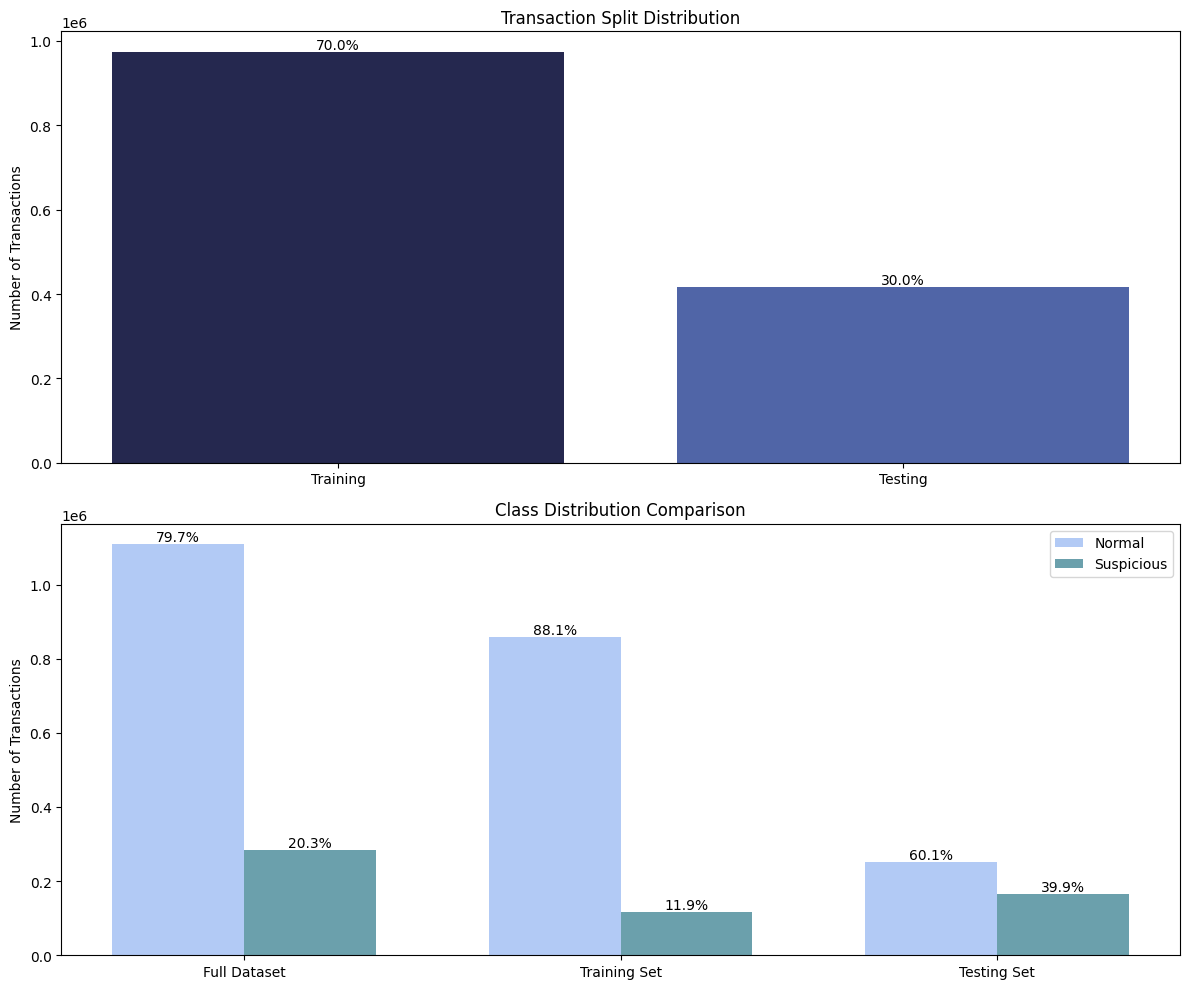

ds2 Overall Dataset Statistics:
Total Transactions: 1,498,177
Total Entities: 14,134
Date Range: 2022-03-15 10:24:00 to 2054-09-15 13:07:24

Class Distribution:
Full Dataset:
Normal transactions: 1,467,358 (97.9%)
Suspicious transactions: 30,819 (2.1%)

Training Set:
Total Transactions: 1,048,873 (70.0% of dataset)
Normal transactions: 1,026,827 (97.9%)
Suspicious transactions: 22,046 (2.1%)

Test Set:
Total Transactions: 449,304 (30.0% of dataset)
Normal transactions: 440,531 (98.0%)
Suspicious transactions: 8,773 (2.0%)

Statistical Analysis:
Chi-square test p-value: 0.0000
Target vs Achieved split difference: 0.0%

Entity Distribution:
Training entities: 9,923 (70.2%)
Testing entities: 4,211 (29.8%)

Temporal Coverage:
Entity cutoff date: 2045-01-03 08:06:24
Training period: 2022-03-15 10:24:00 to 2045-02-28 10:36:24
Testing period: 2045-01-03 08:06:24 to 2054-09-15 13:07:24


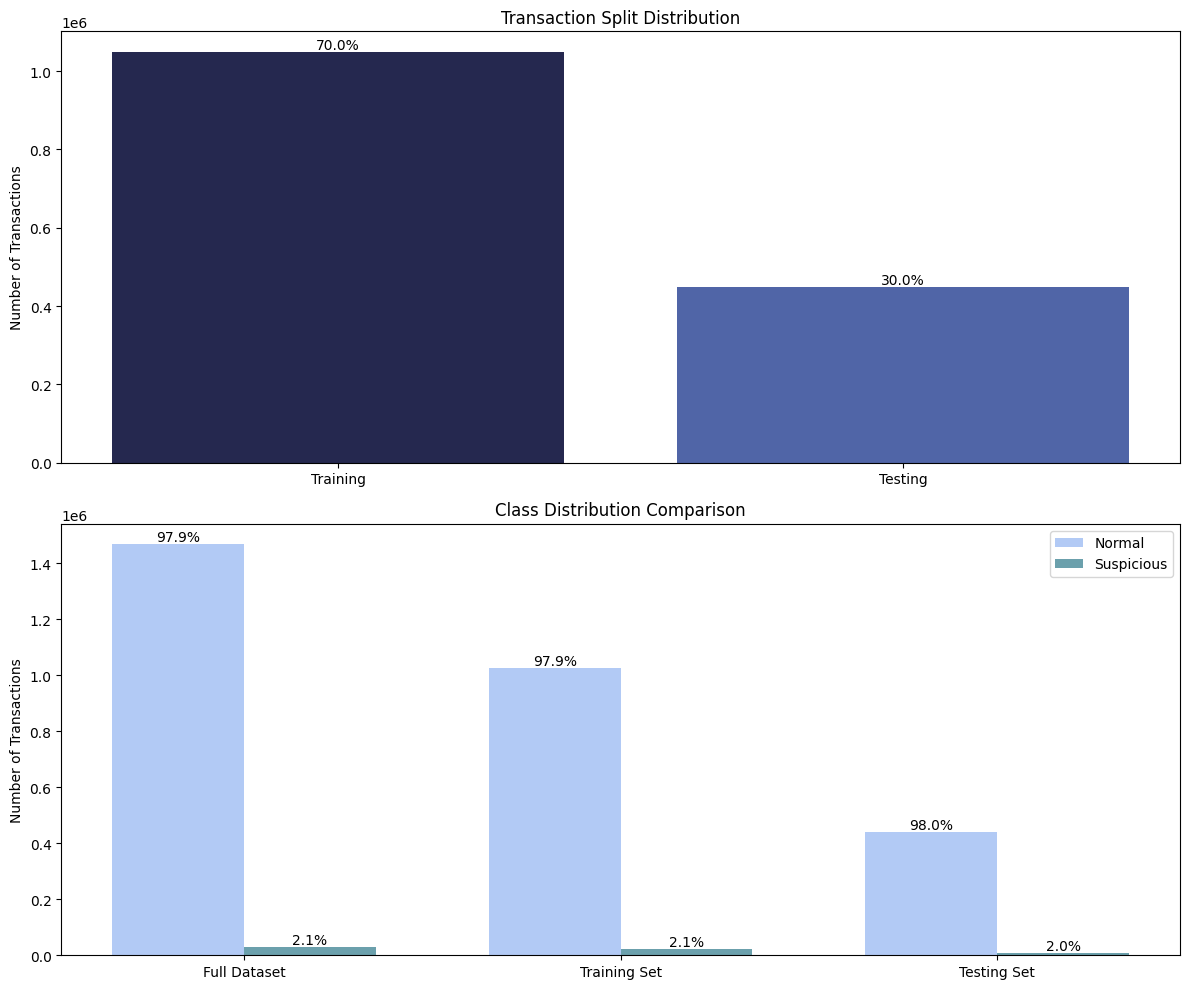

In [3]:
for df, name in zip([df1, df2], ['ds1', 'ds2']):
    train_df, test_df, stats = temporal_entity_split(df)
    print_split_statistics(stats, name)
    train_df.to_parquet(f'../data/split/resplit/{name}_train.parquet')
    test_df.to_parquet(f'../data/split/resplit/{name}_test.parquet')
    plot_distributions(stats, name)

ds3 Overall Dataset Statistics:
Total Transactions: 2,889,341
Total Entities: 45,393
Date Range: 2022-01-07 00:02:00 to 2054-09-15 13:07:24

Class Distribution:
Full Dataset:
Normal transactions: 2,575,679 (89.1%)
Suspicious transactions: 313,662 (10.9%)

Training Set:
Total Transactions: 2,022,747 (70.0% of dataset)
Normal transactions: 1,884,335 (93.2%)
Suspicious transactions: 138,412 (6.8%)

Test Set:
Total Transactions: 866,594 (30.0% of dataset)
Normal transactions: 691,344 (79.8%)
Suspicious transactions: 175,250 (20.2%)

Statistical Analysis:
Chi-square test p-value: 0.0000
Target vs Achieved split difference: 0.0%

Entity Distribution:
Training entities: 31,085 (68.5%)
Testing entities: 14,308 (31.5%)

Temporal Coverage:
Entity cutoff date: 2022-02-12 10:50:00
Training period: 2022-01-07 00:02:00 to 2045-02-28 10:36:24
Testing period: 2022-02-12 10:50:00 to 2054-09-15 13:07:24


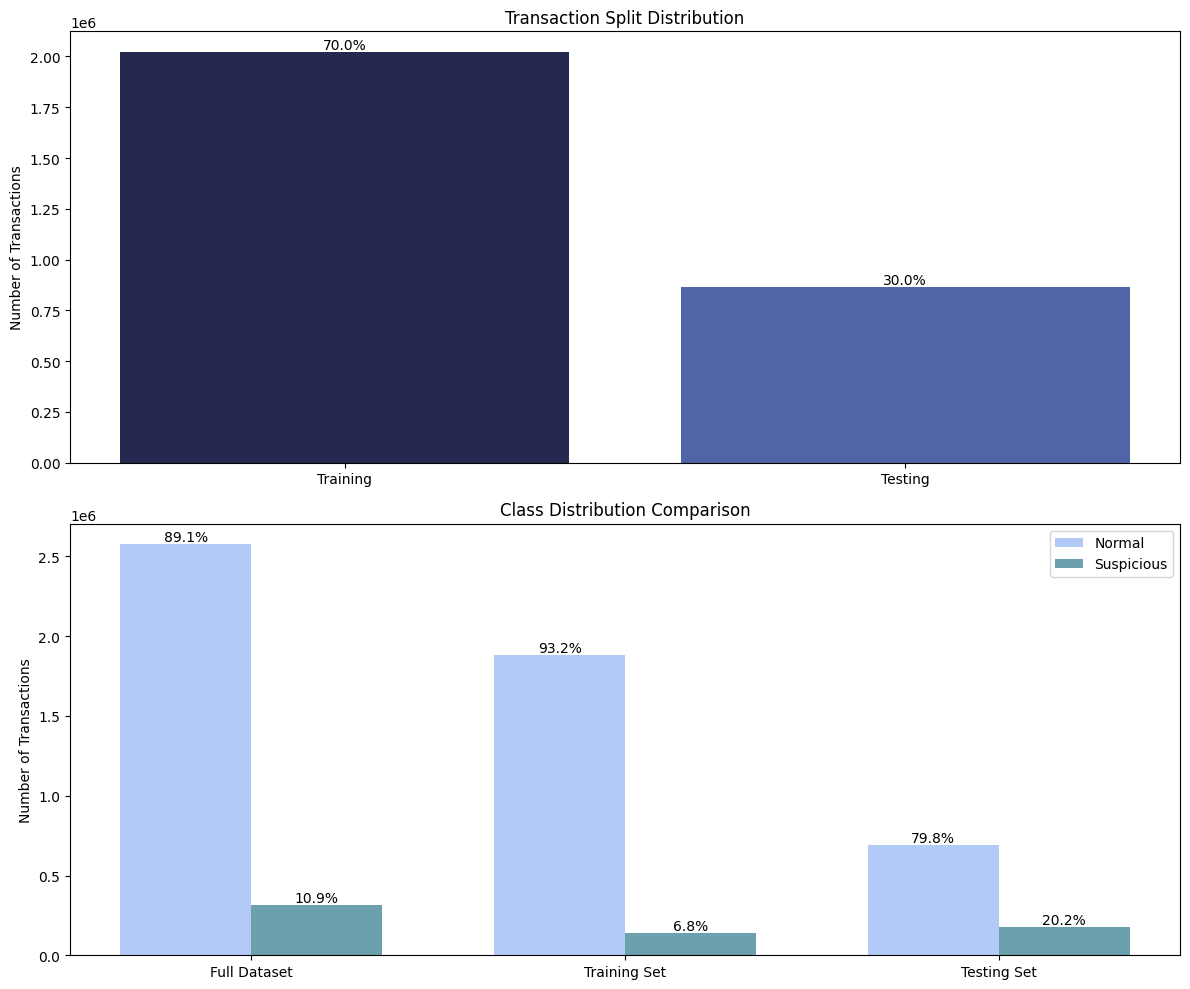

In [4]:
ds1_train = pd.read_parquet('../data/split/resplit/ds1_train.parquet')
ds2_train = pd.read_parquet('../data/split/resplit/ds2_train.parquet')

ds1_test = pd.read_parquet('../data/split/resplit/ds1_test.parquet')
ds2_test = pd.read_parquet('../data/split/resplit/ds2_test.parquet')

ds3_train = pd.concat([ds1_train, ds2_train], ignore_index=True)
ds3_test = pd.concat([ds1_test, ds2_test], ignore_index=True)

ds3_full = pd.concat([df1, df2], ignore_index=True)
ds3_full.to_parquet('../data/jp_morgan/sorted/transaction_metrics_final_ds3_v5_cbflag_mod_metric.parquet')
ds3_train.to_parquet('../data/split/resplit/ds3_train.parquet')
ds3_test.to_parquet('../data/split/resplit/ds3_test.parquet')

stat = calculate_split_statistics(ds3_full, ds3_train, ds3_test, 0.7)
print_split_statistics(stat, 'ds3')
plot_distributions(stat, 'ds3')

In [11]:
import matplotlib.pyplot as plt
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']
